In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

In [3]:
def plot_synthetic_data2(ax, obs, gamma, xs, zs, lams, trial, trial_color):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    # i = 3
        
    ax[0].plot(x, lams[:,0,l], color=trial_color)
    ax[0].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[0].margins(0)
    ax[0].set_ylabel('Intensity', size = label_size)

    ax[2].plot(x, lams[:,1,l], color=trial_color)
    ax[2].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[2].margins(0)
    ax[2].set_ylabel('Intensity', size = label_size)

    ax[1].plot(x, obs[:,0,l], color=trial_color)
    ax[1].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)

    ax[3].plot(x, obs[:,1,l], color=trial_color)
    ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[3].margins(0)
    ax[3].set_ylabel('Intensity', size = label_size)


    ax[3].set_xlabel('Time (sec)', size = label_size)
    # plt.xlim([0,sample_length/fs])


In [4]:
def plot_synthetic_data(ax, obs, gamma, xs, zs, lams, trial, trial_color):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    # i = 3
        
    ax[0].plot(x, lams[:,0,l], color=trial_color)
    ax[0].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[0].margins(0)
    ax[0].set_ylabel('Intensity', size = label_size)

    ax[2].plot(x, lams[:,1,l], color=trial_color)
    ax[2].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[2].margins(0)
    ax[2].set_ylabel('Intensity', size = label_size)

    ax[4].plot(x, lams[:,2,l], color=trial_color)
    ax[4].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[4].margins(0)
    ax[4].set_ylabel('Intensity', size = label_size)

    ax[1].plot(x, obs[:,0,l], color=trial_color)
    ax[1].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)

    ax[3].plot(x, obs[:,1,l], color=trial_color)
    ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[3].margins(0)
    ax[3].set_ylabel('Intensity', size = label_size)

    ax[5].plot(x, obs[:,2,l], color=trial_color)
    ax[5].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[5].margins(0)
    ax[5].set_ylabel('Intensity', size = label_size)


    ax[5].set_xlabel('Time (sec)', size = label_size)
    # plt.xlim([0,sample_length/fs])


In [5]:
from cohlib.jax.dists import sample_from_gamma, sample_obs
from cohlib.jax.observations import add0
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams = lams.at[lams < 0].set(0)
    return lams

In [6]:
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [7]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

for alpha in 100 250 500

do

    for scale_init in 1000 100000 10000000 

In [13]:
num_iters = 20

#1000000 10000000 100000000

# lcfg_attrs = {'L': 25}
alpha = 100
lcfg_attrs = {}

mcfg_attrs = {'emiters': num_iters,
              'init': 'empirical-init'}

ocfg_attrs = {'obs_type': 'pp_relu'}

# res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-12']
# res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/batch/outputs/2024-11-18-large']
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-19']
# for res_path in res_paths:
#     clean_dir(res_path)

res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
Ls = sorted([r['cfg'].latent.L for r in res_load])
alphas = sorted([r['cfg'].obs.alpha for r in res_load])


2 paths found meeting critera


In [14]:
alphas

[100, 300]

In [16]:
alpha = 100
L = 100
lsel = {'L': L}
osel = {'alpha': alpha}
res = filter_loaded(res_load, lsel, {}, osel)
cfg = res['cfg']
gamma_true = res['gamma_true_full']
nz = res['params']['nonzero_inds']

Returned single result.


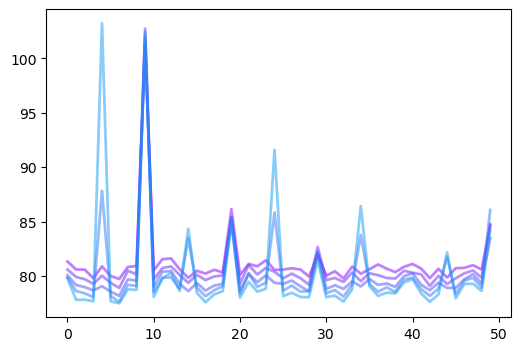

In [17]:
k = 0
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity

fig, ax = plt.subplots(figsize=(6,4))
plot_spec_em_iters(ax, res['track']['gamma'], k, dB=dB)

In [20]:
from cohlib.jax.dists import naive_estimator, sample_ccn_rank1
from cohlib.jax.simtools import load_gamma

L = 100

naive_ests = {}
oracle_ests = {}
for alpha in alphas:
    lsel = {'L': L}
    osel = {'obs_type': 'pp_relu',
            'alpha': alpha}
    res = filter_loaded(res_load, lsel, {}, osel)

    
    cfg = res['cfg']
    lcfg = cfg.latent
    ocfg = cfg.obs
    gamma_true = res['gamma_true_full']
    K = gamma_true.shape[-1]

    
    lrk = jr.key(lcfg.seed)

    zs = sample_from_gamma(lrk, gamma_true, lcfg.L)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)
    params = jnp.array([ocfg.alpha for _ in range(K)])
    print(params)
    lams = cif_alpha_relu(params, xs)


    obs, obs_params = sample_obs(ocfg, xs)
    naive_est = naive_estimator(obs, nz)
    naive_ests[alpha] = naive_est * 1e6

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz,:,:], zs[nz,:,:].conj()).mean(-1)
    oracle_ests[alpha] = gamma_oracle

Returned single result.
[100 100 100]
Returned single result.
[300 300 300]


In [21]:
# naive_ests[100]

In [22]:
# colors = ['tab:blue', 'tab:orange', 'tab:green']
# freqs = jnp.arange(50)
# fig,ax = plt.subplots(6,1,figsize=(10,8), sharex=True)
# for i in range(3):
#     fig,ax = plt.subplots(6,1,figsize=(10,8), sharex=True)
#     plot_synthetic_data(ax, obs, gamma_true, xs, zs, lams, trial=i, trial_color=colors[i])
#     plt.tight_layout()

Returned single result.
Returned single result.


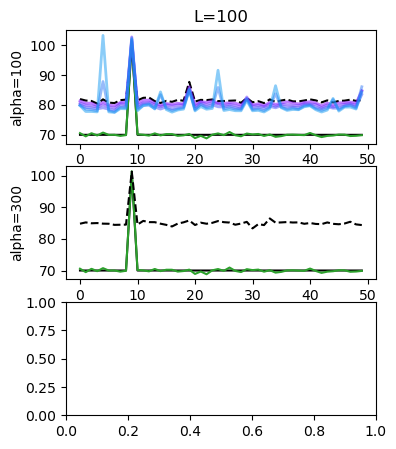

In [24]:
k = 0
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity

L = 100
fig, ax = plt.subplots(3,1,figsize=(4,5))
for i, alpha in enumerate(alphas):
        lsel = {'L': L}

        msel = {'emiters': num_iters,
                    'init': 'empirical-init'}

        osel = {'obs_type': 'pp_relu',
                    'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)

        gamma_true = res['gamma_true_full']
        gamma_est = res['gamma']
        nz = res['params']['nonzero_inds']
        ax[i].plot(transform(gamma_true[nz,k,k].real), color='k')
        ax[i].plot(transform(gamma_est[nz,k,k].real), color='tab:blue')
        ax[i].plot(transform(oracle_ests[alpha][nz,k,k].real), color='tab:green')
        ax[i].plot(transform(naive_ests[alpha][nz,k,k].real), color='k', linestyle='--')
        plot_spec_em_iters(ax[i], res['track']['gamma'], k, dB=dB)
        if i == 0:
            ax[i].set_title(f'L={L}')
        ax[i].set_ylabel(f'alpha={alpha}')

In [22]:
def plot_cross_spec_em_iters(ax, i, j, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    cs_real = jnp.array([gamma_init[j_ind,i,j].real] + [gamma_r[j_ind,i,j].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind,i,j].imag] + [gamma_r[j_ind,i,j].imag for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color='tab:blue', linewidth=2)
    ax.plot(cs_imag, color='tab:red', linewidth=2)

def plot_cross_spec_func_em_iters(ax, func, i, j, gamma_iter_list, gamma_init, j_ind=9, nz=None, color='tab:blue'):
    cs_real = jnp.array([func(gamma_init[j_ind,i,j])] + [func(gamma_r[j_ind,i,j]) for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color=color, linewidth=2)

In [25]:
alpha = 300
lsel = {'L': 100}
osel = {'alpha': alpha}
res = filter_loaded(res_load, lsel, {}, osel)
cfg = res['cfg']
gamma_true = res['gamma_true_full']
nz = res['params']['nonzero_inds']

Returned single result.


In [26]:
res['gamma']

Array([[[nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj]],

       [[nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj]],

       [[nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj]],

       ...,

       [[ 0. +0.j,  0. +0.j,  0. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j]],

       [[ 0. +0.j,  0. +0.j,  0. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j]],

       [[ 0. +0.j,  0. +0.j,  0. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j]]], dtype=complex64)

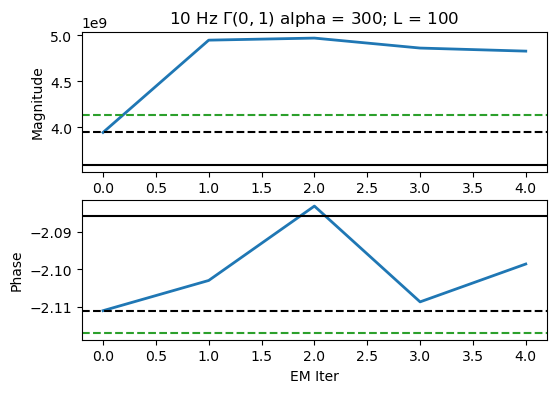

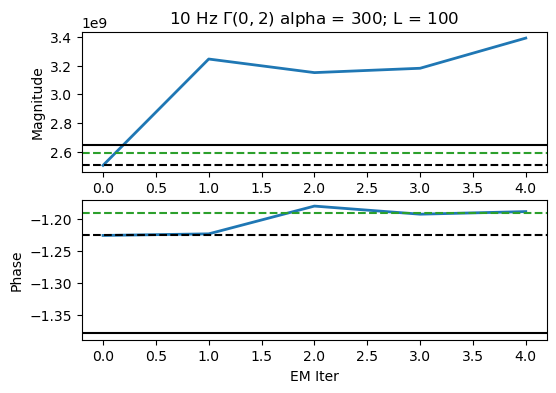

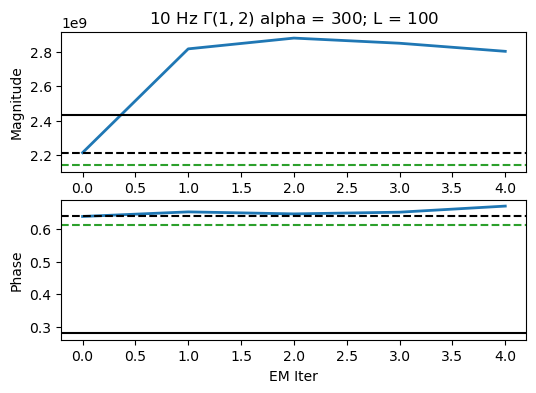

In [27]:
jind = 9 
i = 1
j = 2
ijs = [[0,1], [0,2], [1,2]]

for ij in ijs:
    i, j = ij
    fig, ax = plt.subplots(2,1, figsize=(6,4))
    func = jnp.abs
    plot_cross_spec_func_em_iters(ax[0], func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
    ax[0].axhline(func(res['gamma_true_full'][jind,i,j]), color='k')
    ax[0].axhline(func(naive_ests[alpha][jind,i,j]), linestyle='--', color='k')
    ax[0].axhline(func(oracle_ests[alpha][jind,i,j]), linestyle='--', color='tab:green')
    ax[0].set_title(f'{jind+1} Hz ' + rf'$\Gamma({i}, {j})$' + f' alpha = {alpha}; L = {L}')
    ax[0].set_ylabel('Magnitude')

    func = jnp.angle
    plot_cross_spec_func_em_iters(ax[1], func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
    ax[1].axhline(func(res['gamma_true_full'][jind,i,j]), color='k')
    ax[1].axhline(func(naive_ests[alpha][jind,i,j]), linestyle='--', color='k')
    ax[1].axhline(func(oracle_ests[alpha][jind,i,j]), linestyle='--', color='tab:green')
    ax[1].set_ylabel('Phase')
    ax[1].set_xlabel('EM Iter')
    # ax[1].set_ylim([-3.14,3.14])


In [173]:
res['gamma'][9,0,0].real

Array(1.2793463e+10, dtype=float32)

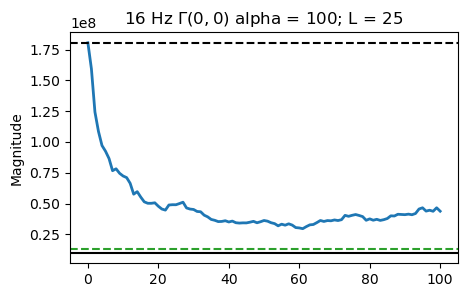

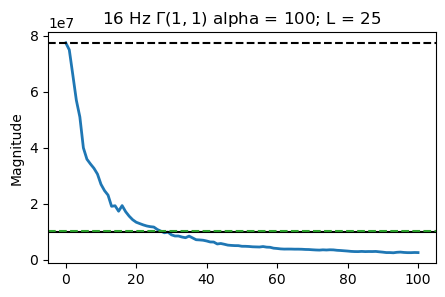

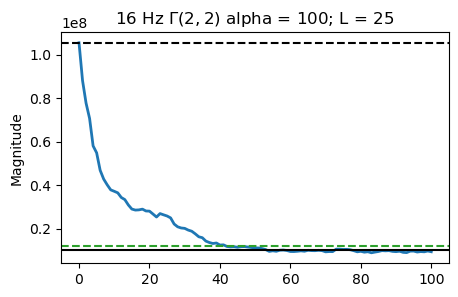

In [174]:

jind = 15 
ijs = [[0,0], [1,1], [2,2]]

for ij in ijs:
    i, j = ij
    fig, ax = plt.subplots(figsize=(5,3))
    func = jnp.real
    plot_cross_spec_func_em_iters(ax, func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
    ax.axhline(func(res['gamma_true_full'][jind,i,j]), color='k')
    ax.axhline(func(naive_ests[alpha][jind,i,j]), linestyle='--', color='k')
    ax.axhline(func(oracle_ests[alpha][jind,i,j]), linestyle='--', color='tab:green')
    ax.set_title(f'{jind+1} Hz ' + rf'$\Gamma({i}, {j})$' + f' alpha = {alpha}; L = {L}')
    ax.set_ylabel('Magnitude')

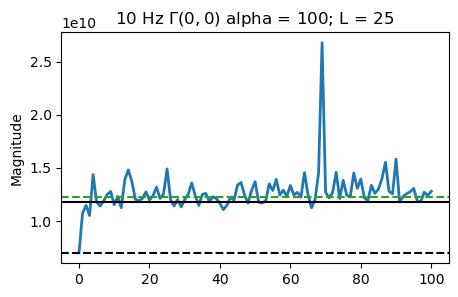

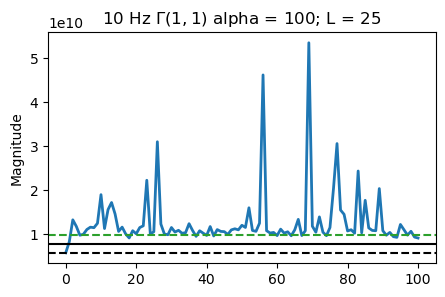

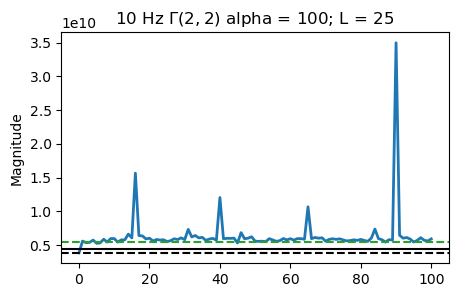

In [175]:
jind = 9 
ijs = [[0,0], [1,1], [2,2]]

for ij in ijs:
    i, j = ij
    fig, ax = plt.subplots(figsize=(5,3))
    func = jnp.real
    plot_cross_spec_func_em_iters(ax, func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
    ax.axhline(func(res['gamma_true_full'][jind,i,j]), color='k')
    ax.axhline(func(naive_ests[alpha][jind,i,j]), linestyle='--', color='k')
    ax.axhline(func(oracle_ests[alpha][jind,i,j]), linestyle='--', color='tab:green')
    ax.set_title(f'{jind+1} Hz ' + rf'$\Gamma({i}, {j})$' + f' alpha = {alpha}; L = {L}')
    ax.set_ylabel('Magnitude')

In [170]:
jnp.diag(res['track']['gamma'][0][9,:,:])

Array([1.4166207e+10-10473318.j , 1.1459721e+10 +1662249.1j,
       6.2251571e+09 +2256205.2j], dtype=complex64)

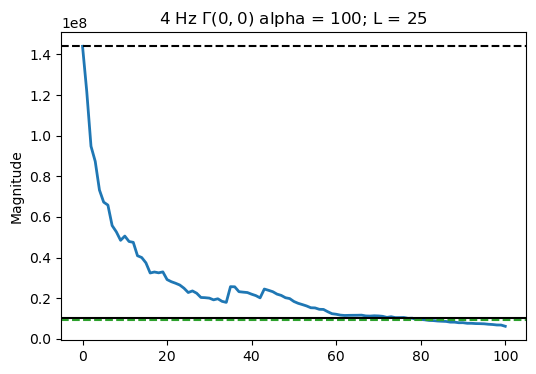

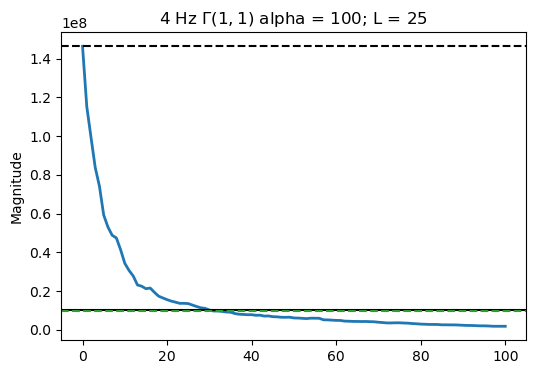

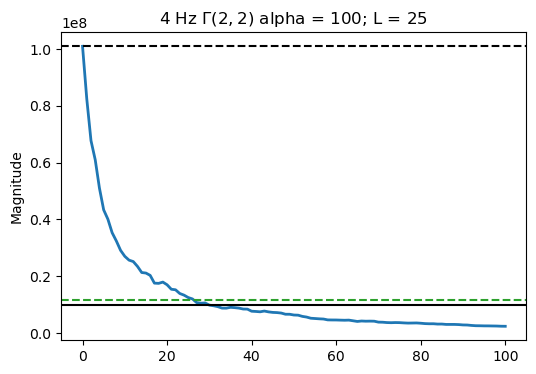

In [143]:
jind = 3 
ijs = [[0,0], [1,1], [2,2]]

for ij in ijs:
    i, j = ij
    fig, ax = plt.subplots(figsize=(6,4))
    func = jnp.abs
    plot_cross_spec_func_em_iters(ax, func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
    ax.axhline(func(res['gamma_true_full'][jind,i,j]), color='k')
    ax.axhline(func(naive_ests[alpha][jind,i,j]), linestyle='--', color='k')
    ax.axhline(func(oracle_ests[alpha][jind,i,j]), linestyle='--', color='tab:green')
    ax.set_title(f'{jind+1} Hz ' + rf'$\Gamma({i}, {j})$' + f' alpha = {alpha}; L = {L}')
    ax.set_ylabel('Magnitude')

In [86]:
rf'$\alpha > {j}$'

'$\\alpha > 1$'

In [29]:
alpha = 100aa

lcfg_attrs = {'L': 50}

mcfg_attrs = {'emiters': num_iters,
            'init': 'empirical-init'}

ocfg_attrs = {'obs_type': 'pp_relu',
            'alpha': alpha}
res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
res = res_load[0]

1 paths found meeting critera


In [30]:
print(jnp.round(res['gamma'][9,:,:], -7))

[[ 1.261e+10+1.00e+07j -3.500e+08-3.44e+09j  1.850e+09-2.92e+09j]
 [-3.500e+08+3.44e+09j  9.490e+09-0.00e+00j  2.860e+09+7.00e+08j]
 [ 1.850e+09+2.92e+09j  2.860e+09-7.00e+08j  5.000e+09+0.00e+00j]]


In [32]:
print(jnp.linalg.eigh(res['gamma'][9,:,:])[0].sort()[::-1])

def get_eigval(mat, rank):
    eigvals_sorted = jnp.linalg.eigh(mat)[0].sort()[::-1]
    return eigvals_sorted[rank]

get_eigval(res['gamma'][9,:,:], 0)

[1.6543093e+10 7.4899942e+09 3.0713326e+09]


Array(1.6543093e+10, dtype=float32)

In [33]:
def plot_cross_spec_eigval_em_iters(ax, eigrank, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    # cs_real = jnp.array([gamma_init[j_ind,i,j].real] + [gamma_r[j_ind,0,1].real for gamma_r in gamma_iter_list])
    # cs_imag = jnp.array([gamma_init[j_ind,i,j].imag] + [gamma_r[j_ind,0,1].imag for gamma_r in gamma_iter_list])
    eigs = jnp.array([get_eigval(gamma_init[j_ind,:,:], eigrank)] + [get_eigval(gamma_r[j_ind,:,:], eigrank) for gamma_r in gamma_iter_list])
    # init_val = jnp.linalg.eigh(gamma_init[j_ind,:,:])[0].sort()[::-1]

    ax.plot(eigs, color='tab:blue', linewidth=2)
    # ax.plot(cs_imag, color='tab:red', linewidth=2)

In [35]:
j_ind = 9
eigrank = 0
true_eigvals = jnp.linalg.eigh(res['gamma_true_full'][9,:,:])[0].sort()[::-1]


# plot_cross_spec_eigval_em_iters(ax, eigrank, res['track']['gamma'], res['gamma_init'], j_ind=j_ind)
# ax.axhline(true_eigvals[eigrank], linestyle='--', color='k')

1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera


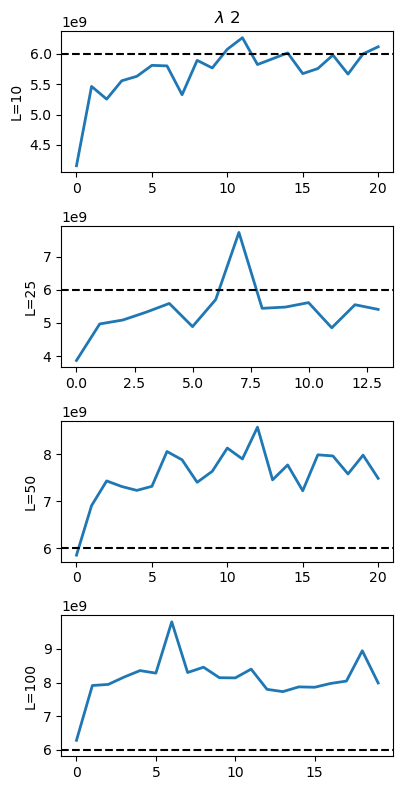

In [40]:
j_ind = 9
eigrank = 1
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity

fig, ax = plt.subplots(4,1,figsize=(4,8))
Ls = [10, 25, 50, 100]
for i, L in enumerate(Ls):
        lcfg_attrs = {'L': L}

        mcfg_attrs = {'emiters': num_iters,
                    'init': 'empirical-init'}                    

        ocfg_attrs = {'obs_type': 'pp_relu',
                    'alpha': alpha}
        res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
        assert len(res_load) == 1
        res = res_load[0]

        gamma_true = res['gamma_true_full']
        gamma_est = res['gamma']
        nz = res['params']['nonzero_inds']
        plot_cross_spec_eigval_em_iters(ax[i], eigrank, res['track']['gamma'], res['gamma_init'], j_ind=j_ind)
        ax[i].axhline(true_eigvals[eigrank], linestyle='--', color='k')
        if i == 0:
            ax[i].set_title(r'$\lambda$ ' f'{eigrank+1}')
        ax[i].set_ylabel(f'L={L}')
plt.tight_layout()

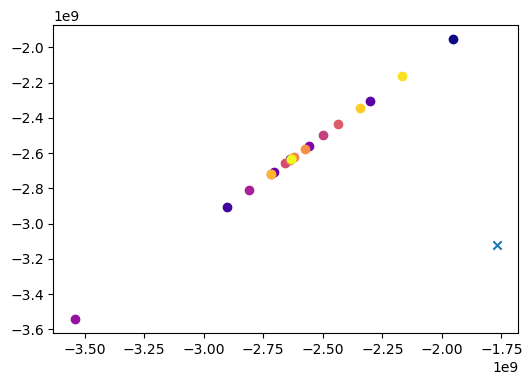

In [49]:
def plot_cross_spec_em_iters(ax, i, j, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    N = len(gamma_iter_list)
    color = plt.cm.plasma(jnp.linspace(0, 1, N))
    cs_real = jnp.array([gamma_init[j_ind,i,j].real] + [gamma_r[j_ind,i,j].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind,i,j].imag] + [gamma_r[j_ind,i,j].imag for gamma_r in gamma_iter_list])
    # ax.plot(cs_real, color='tab:blue', linewidth=2)
    # ax.plot(cs_imag, color='tab:red', linewidth=2)
    for n in range(N):
        ax.scatter(cs_real[n], cs_real[n], color=color[n]) 

jind = 9 
i = 0
j = 1
fig, ax = plt.subplots(figsize=(6,4))
plot_cross_spec_em_iters(ax, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)

true_real = res['gamma_true_full'][jind,i,j].real
true_imag = res['gamma_true_full'][jind,i,j].imag

ax.scatter(true_real, true_imag, marker='x')

# ax.axhline(res['gamma_true_full'][jind,i,j].real, linestyle='--', color='tab:blue')
# ax.axhline(res['gamma_true_full'][jind,i,j].imag, linestyle='--', color='tab:red')

1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera


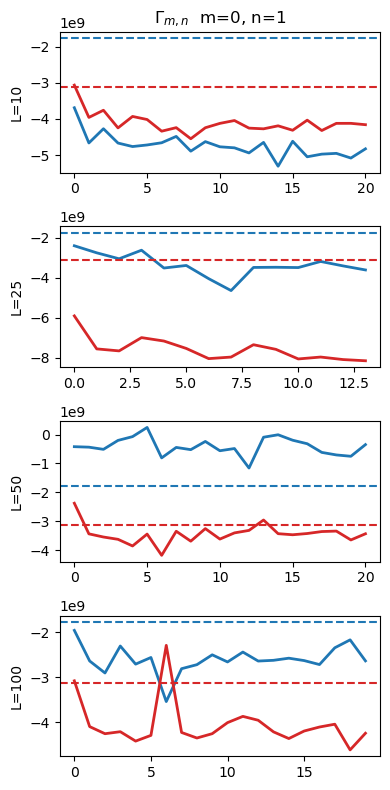

In [45]:
j_ind = 9
m=0
n=1
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity

fig, ax = plt.subplots(4,1,figsize=(4,8))
Ls = [10, 25, 50, 100]
for i, L in enumerate(Ls):
        lcfg_attrs = {'L': L}

        mcfg_attrs = {'emiters': num_iters,
                    'init': 'empirical-init'}

        ocfg_attrs = {'obs_type': 'pp_relu',
                    'alpha': alpha}
        res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
        assert len(res_load) == 1
        res = res_load[0]

        gamma_true = res['gamma_true_full']
        gamma_est = res['gamma']
        nz = res['params']['nonzero_inds']
        plot_cross_spec_em_iters(ax[i], m,n, res['track']['gamma'], res['gamma_init'], j_ind = jind)
        ax[i].axhline(res['gamma_true_full'][jind,m,n].real, linestyle='--', color='tab:blue')
        ax[i].axhline(res['gamma_true_full'][jind,m,n].imag, linestyle='--', color='tab:red')
        if i == 0:
            ax[i].set_title(r'$\Gamma_{m,n}$' f'  m={m}, n={n}')
        ax[i].set_ylabel(f'L={L}')
plt.tight_layout()

In [64]:
L = 50
lcfg_attrs = {'L': L}

mcfg_attrs = {'emiters': num_iters,
            'init': 'empirical-init'}

ocfg_attrs = {'obs_type': 'pp_relu',
            'alpha': alpha}
res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
assert len(res_load) == 1
res = res_load[0]

1 paths found meeting critera


Array([[ 1.1894566e+10-1.8804864e+06j, -1.3407057e+08-3.1996588e+09j,
         1.6660360e+09-2.5806405e+09j],
       [-1.3395457e+08+3.1997161e+09j,  8.3733171e+09-8.2961885e+06j,
         2.5558305e+09+5.4217286e+08j],
       [ 1.6660886e+09+2.5805924e+09j,  2.5558208e+09-5.4246048e+08j,
         4.3174605e+09+8.6966756e+05j]], dtype=complex64)

In [67]:
print(res['gamma'][9,:,:].real)
print(res['gamma_true_full'][9,:,:].real)


[[ 1.1894566e+10 -1.3407057e+08  1.6660360e+09]
 [-1.3395457e+08  8.3733171e+09  2.5558305e+09]
 [ 1.6660886e+09  2.5558208e+09  4.3174605e+09]]
[[ 1.1752302e+10 -1.7668977e+09  5.0665741e+08]
 [-1.7668975e+09  7.7485005e+09  2.3370752e+09]
 [ 5.0665741e+08  2.3370752e+09  4.4991990e+09]]
